# 0300 XGBoost
メリット
- ブースティングによる予測精度の向上: XGBoostは、複数の弱い学習器（通常は決定木）を逐次的に学習させるブースティングという手法を採用。各学習器は前の学習器の誤差を修正するように学習するため、アンサンブル全体として高い予測精度を実現。一方、ランダムフォレストは、複数の決定木を独立に学習させ、その予測結果を平均化または多数決で決定するバギングという手法を用いる。
- 過学習の抑制: XGBoostは、L1およびL2正則化という過学習を防ぐための仕組みを内蔵。これにより、モデルが複雑になりすぎるのを抑制し、未知のデータに対する汎化性能を高める。

デメリット
- 解釈性の低下: ランダムフォレストの方が、個々の決定木が比較的独立しているため、モデル全体の挙動をある程度解釈しやすい。
- 複雑なパラメータチューニング: 調整すべきハイパーパラメータがランダムフォレストよりも多く、良い性能を得るのに複雑なチューニングが必要。

In [51]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from constants import *

plt.style.use('ggplot')
sns.set_palette('winter')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
data = pd.read_csv(os.path.join(RAW_PATH, '0200_data.csv'), index_col=0)
data.columns

Index(['log_price', 'log_total_sf', 'has_2nd', 'has_bsmt', 'has_garage',
       'has_pool', 'has_central_air', 'has_fireplace', 'house_age',
       'remod_age', 'total_porch_sf', 'neighbor_weight', 'year_price',
       'OverallQual', 'OverallCond', 'GarageCars', 'LotFrontage',
       'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20',
       'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50',
       'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80',
       'MSSubClass_85', 'MSSubClass_90', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'ExterQual_Fa', 'ExterQual_Gd',
       'ExterQual_TA', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po',
       'ExterCond_TA', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA',
       'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'KitchenQual_Fa',
       'KitchenQual_Gd', 'KitchenQual_TA', 'Utilities_NoSeWa', 'PoolQC_Fa',
       'PoolQC_Gd', 'Functional_Maj2', 'Functional_Min1', 'Functional

In [53]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

test = XGBRegressor(n_jobs=-1, random_state=86)

test.fit(X_train, y_train)
y_pred = test.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Test: XGBRegressor')
print(f'  RMSE: {round(rmse, 4)}')
print(f'  R2: {round(r2, 4)}')

Test: XGBRegressor
  RMSE: 0.1537
  R2: 0.8581


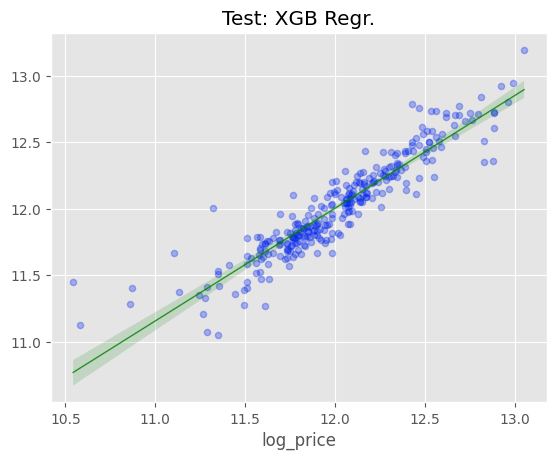

In [54]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Test: XGB Regr.")
plt.show()

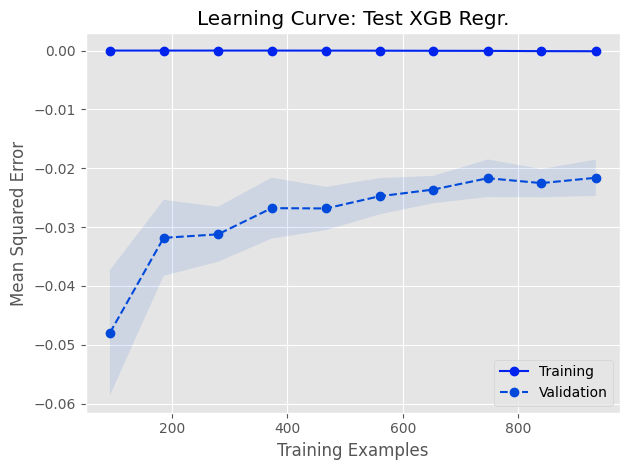

In [55]:
from utils import plot_learning_curve

plot_learning_curve(XGBRegressor(random_state=86, n_jobs=-1), X_train, y_train, title="Learning Curve: Test XGB Regr.")
plt.show()

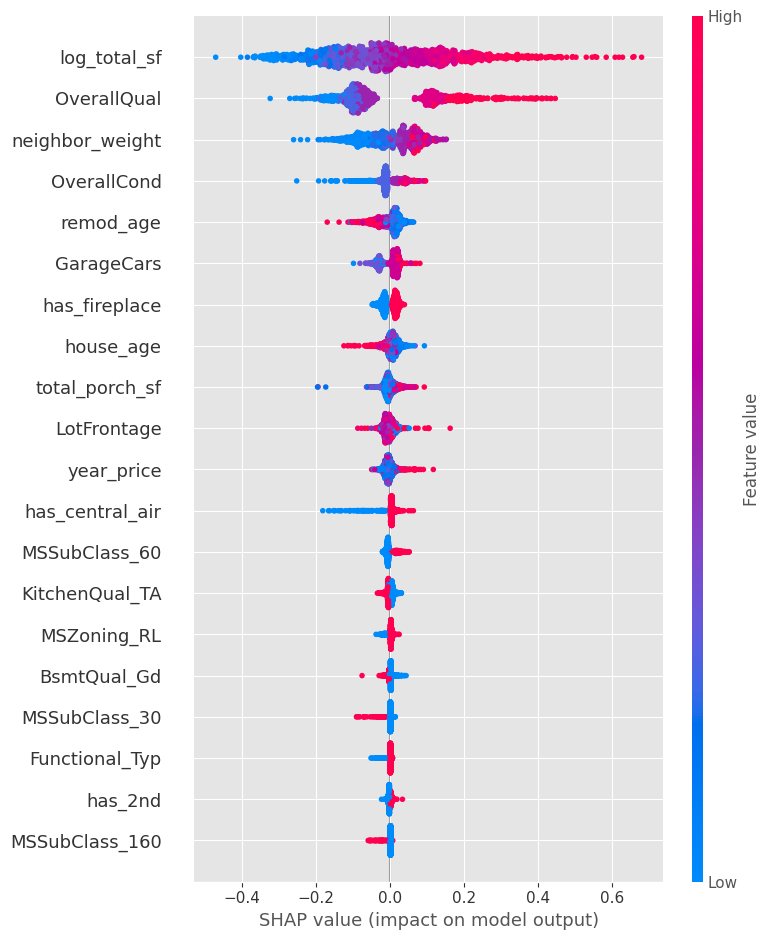

In [56]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model=test)
shap_values1 = explainer.shap_values(X)
shap.summary_plot(shap_values1, X)

In [57]:
shap.force_plot(base_value=explainer.expected_value,
                shap_values=shap_values1[1],
                features=X.iloc[1, :])

In [ ]:
import optuna

def objective(trial):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.001, 10, log=True),
        }
    
    model = XGBRegressor(
        **params,
        random_state=86,
        n_jobs=-1
        )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [58]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300, n_jobs=-1)


[I 2025-05-19 11:43:45,591] A new study created in memory with name: no-name-8d0c827e-34b2-41c1-b2dd-e4dbf0b51992
[I 2025-05-19 11:43:46,018] Trial 3 finished with value: 0.22807613658320933 and parameters: {'learning_rate': 0.8447534436442271, 'max_depth': 18, 'min_child_weight': 10, 'subsample': 0.8427765560026431, 'colsample_bytree': 0.9905100881790468, 'gamma': 6.189415896338127}. Best is trial 3 with value: 0.22807613658320933.
[I 2025-05-19 11:43:46,051] Trial 4 finished with value: 0.20426444869718982 and parameters: {'learning_rate': 0.16008029248155628, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.5635387400348211, 'colsample_bytree': 0.9456638687240059, 'gamma': 4.834265769212123}. Best is trial 4 with value: 0.20426444869718982.
[I 2025-05-19 11:43:46,064] Trial 1 finished with value: 0.1407954790777605 and parameters: {'learning_rate': 0.24406530914260324, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.3862391335512448, 'colsample_bytree': 0.85405005262413

In [60]:
study.best_params, study.best_value

({'learning_rate': 0.06258673844191955,
  'max_depth': 30,
  'min_child_weight': 6,
  'subsample': 0.575309470827,
  'colsample_bytree': 0.7570165472459157,
  'gamma': 0.2323178887112457},
 0.11674569213833685)

In [61]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_child_weight (IntDistribution):
                                0.0054325283658353315<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.016008320614851704<extra></extra>, max_depth
                                (IntDistribution):
                                0.02612520280650576<extra></extra>, subsample
                                (FloatDistribution):
                                0.03489158083334429<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.17259165142510063<extra></extra>, gamma
                                (FloatDistribution):
                                0.7449507159543625<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.02, 0.03, 0.03, 0.17, 0.74],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0054325283658353315, 0.016008320614851704,
                    0.02612520280650576, 0.03489158083334429, 0.17259165142510063,
                    0.7449507159543625],
              'y': [min_child_weight, colsample_bytree, max_depth, subsample,
                    learning_rate, gamma]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=88)

best_params = study.best_params

opt_xgb = XGBRegressor(
    **best_params,
    random_state=88,
    n_jobs=-1
    )

opt_xgb.fit(X_train, y_train)
y_pred = opt_xgb.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Optimized XGB')    
print(f'  RMSE: {round(rmse, 4)}')
print(f'  R2: {round(r2, 4)}')


Optimized XGB
  RMSE: 0.138
  R2: 0.8763


### 過学習を抑制するために正則化
#### L1正則化
まずはL1正則化（reg_alpha）を調整

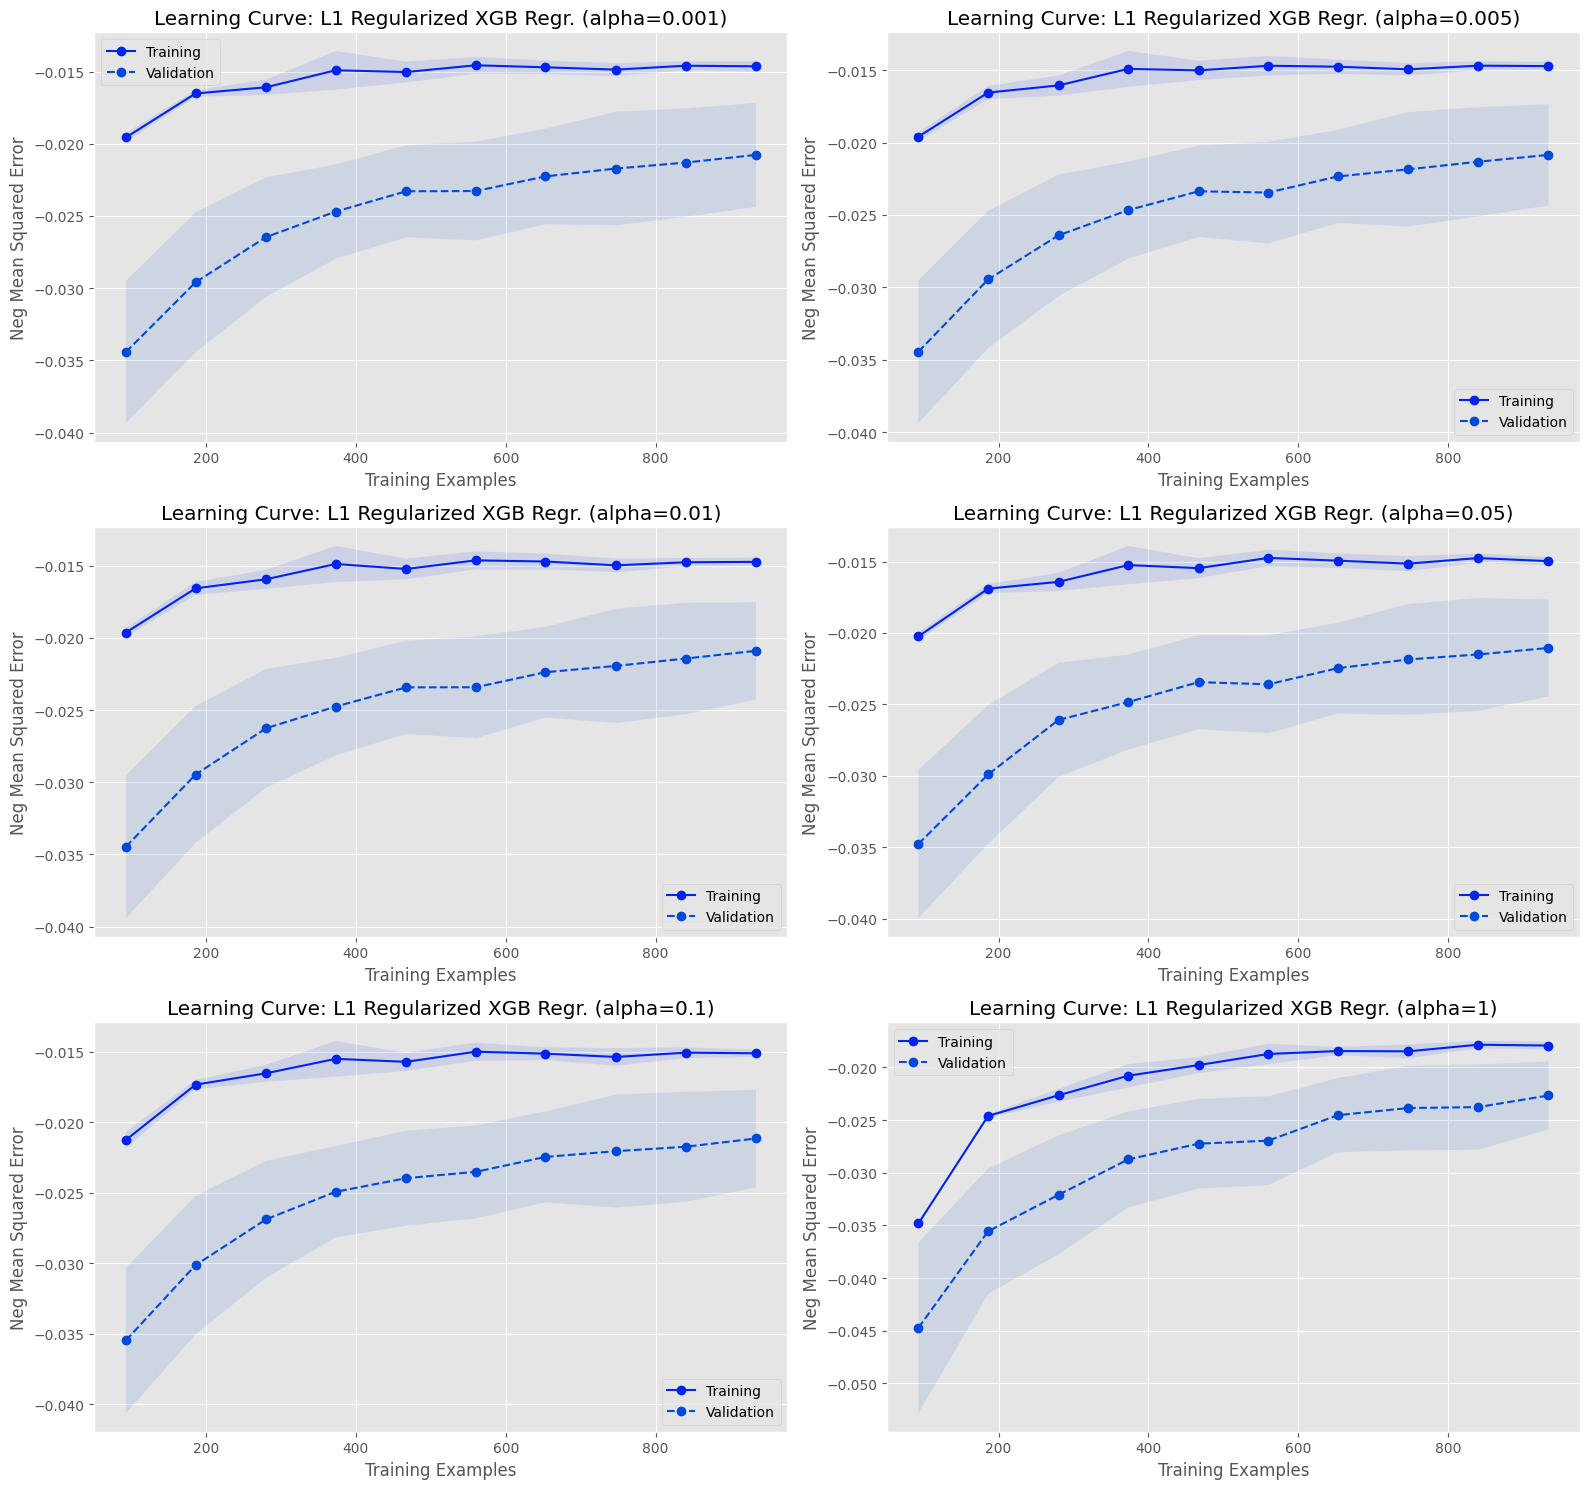

In [72]:
from utils import plot_learning_curve

alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 1]

plt.figure(figsize=(16, 15))

for i, alpha in enumerate(alphas):
    plt.subplot(3, 2, i+1)
    
    plot_learning_curve(
        XGBRegressor(**best_params, reg_alpha=alpha, random_state=88, n_jobs=-1),
        X_train, y_train,
        title=f"Learning Curve: L1 Regularized XGB Regr. (alpha={alpha})"
        )
    plt.tight_layout()
plt.savefig(os.path.join(IMAGE_PATH, '0300_xgb_l1.png'))
plt.show()

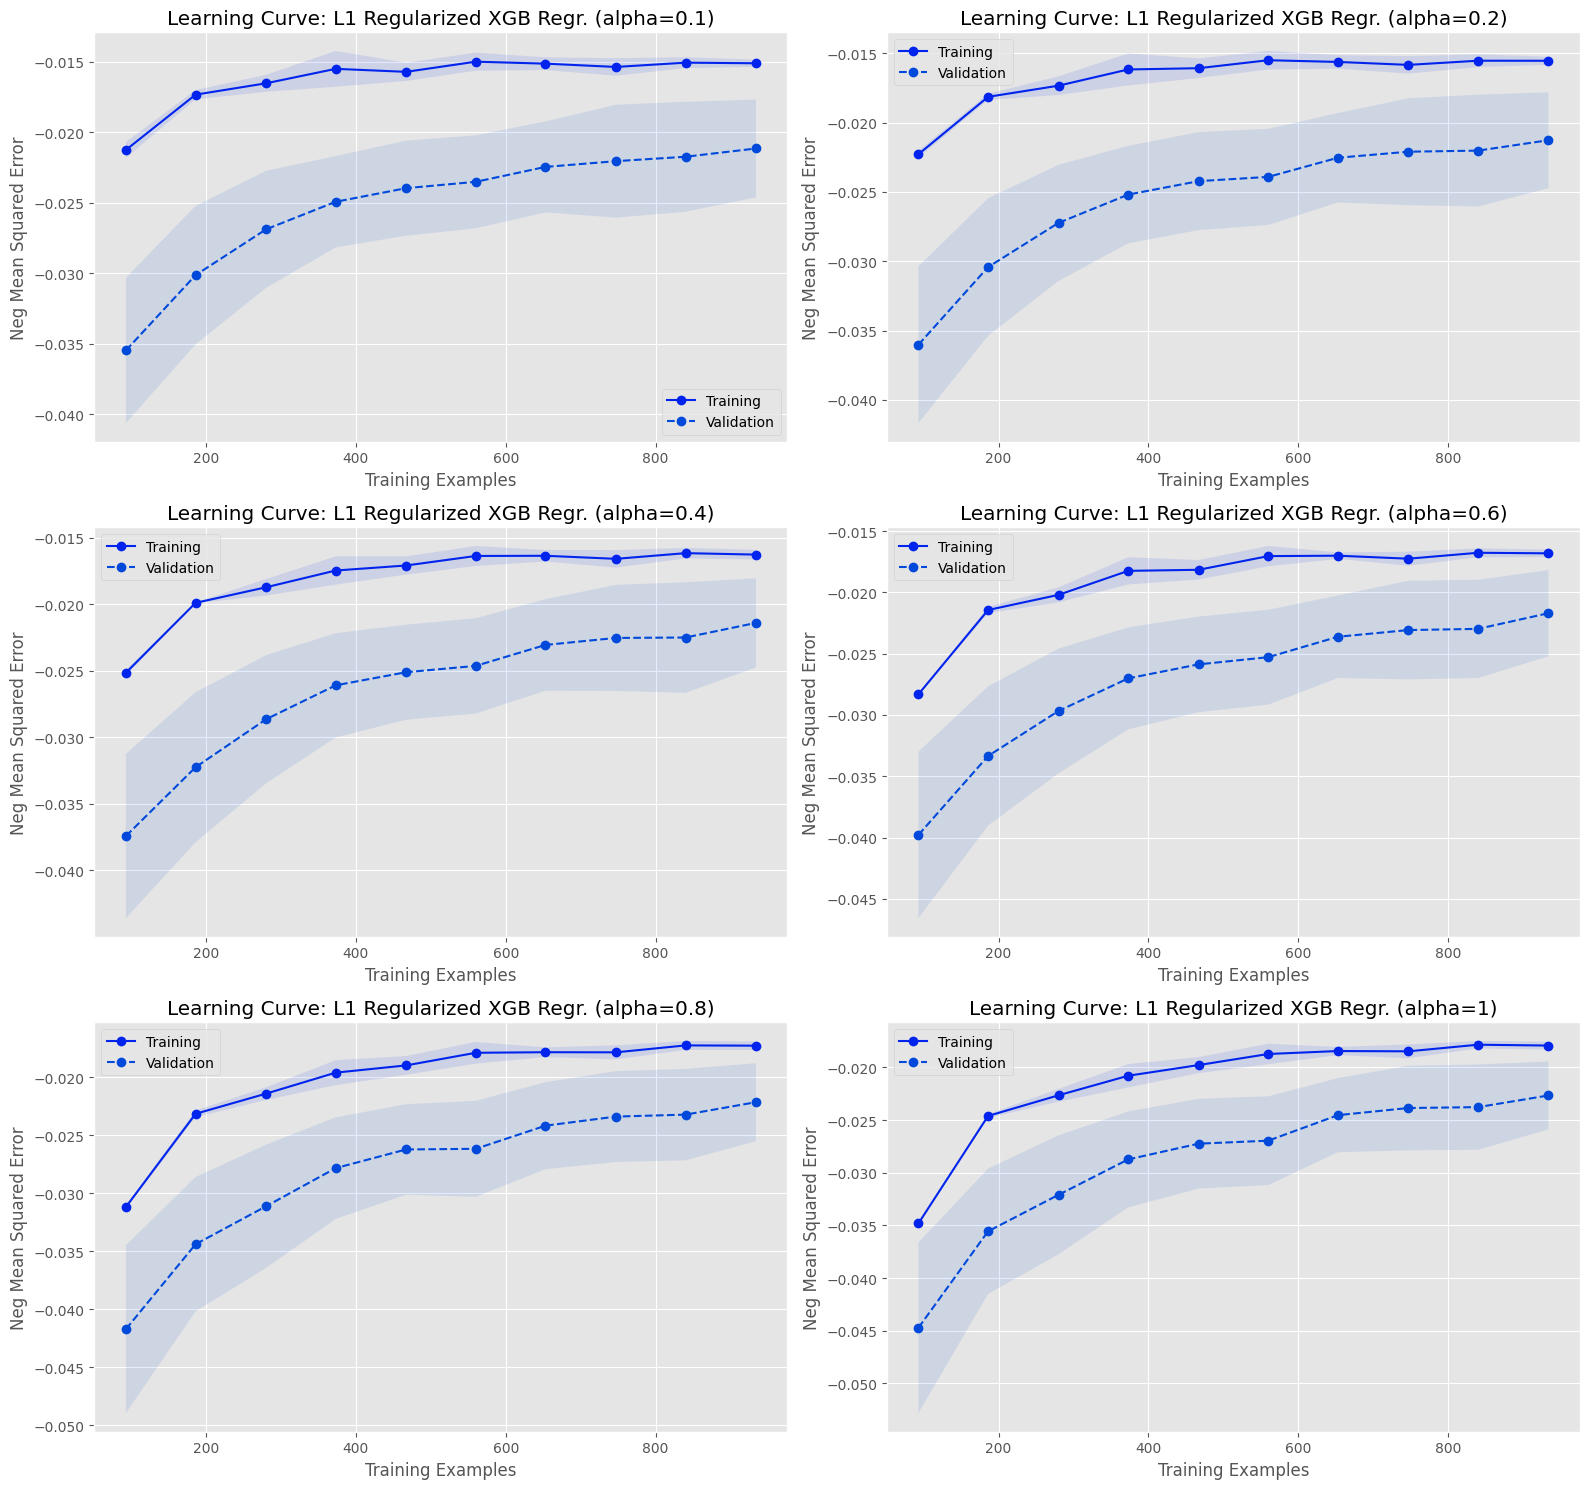

In [73]:
alphas = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

plt.figure(figsize=(16, 15))

for i, alpha in enumerate(alphas):
    plt.subplot(3, 2, i+1)
    
    plot_learning_curve(
        XGBRegressor(**best_params, reg_alpha=alpha, random_state=88, n_jobs=-1),
        X_train, y_train,
        title=f"Learning Curve: L1 Regularized XGB Regr. (alpha={alpha})"
        )
    plt.tight_layout()
plt.savefig(os.path.join(IMAGE_PATH, '0301_xgb_l1.png'))
plt.show()

#### L2正則化（reg_lambda）

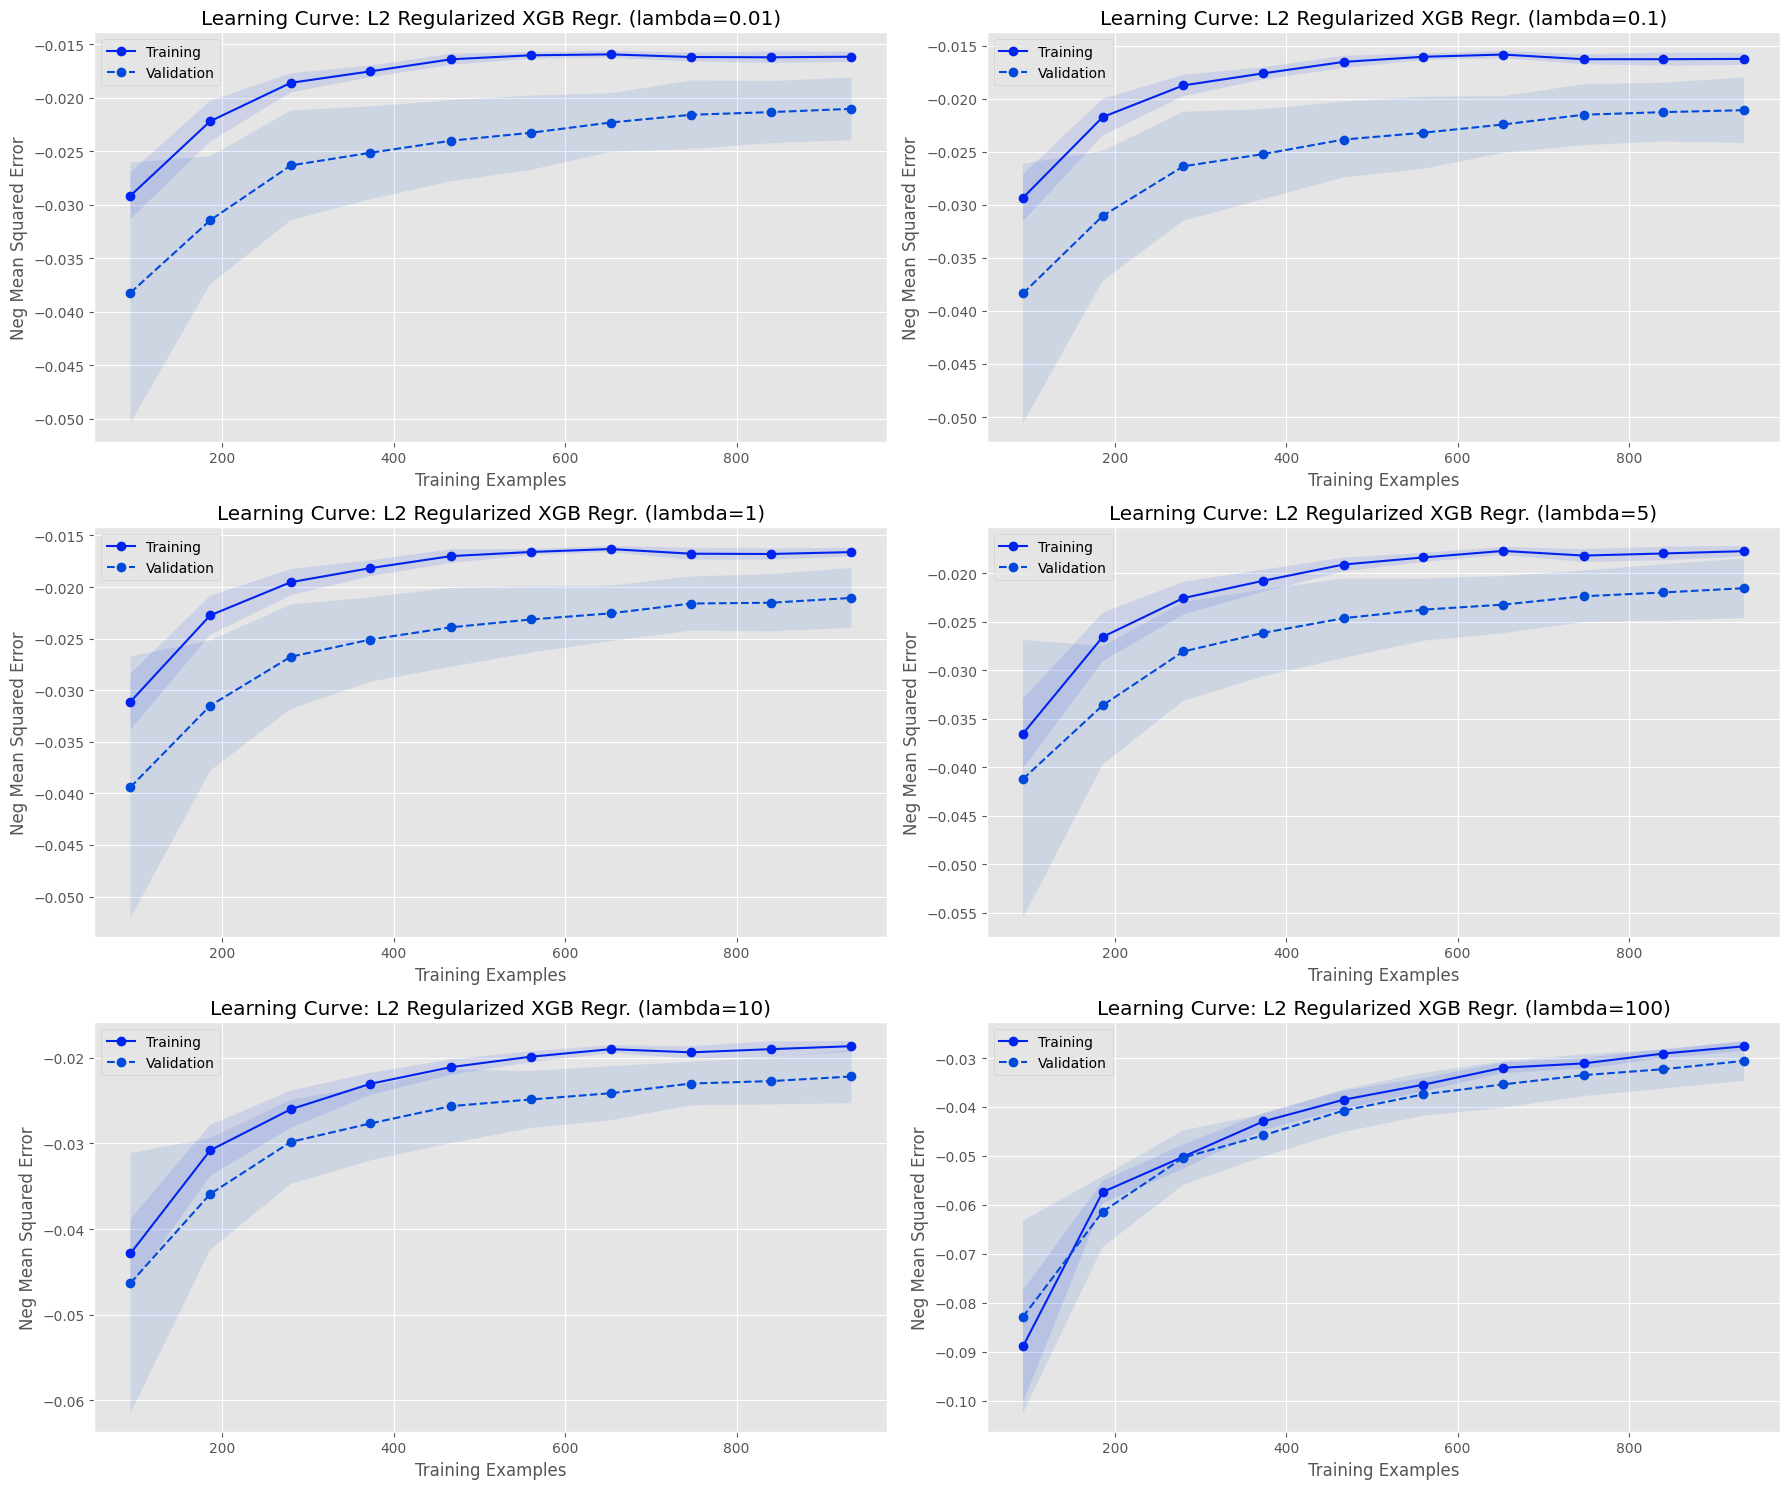

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=86)

alpha = 0.6
lambdas = [0.01, 0.1, 1, 5, 10, 100]

plt.figure(figsize=(18, 15))

for i, lamb in enumerate(lambdas):

    plt.subplot(3, 2, i+1)
    
    plot_learning_curve(
        XGBRegressor(**best_params, reg_alpha=alpha, reg_lambda=lamb, random_state=14, n_jobs=-1),
        X_train, y_train,
        title=f"Learning Curve: L2 Regularized XGB Regr. (lambda={lamb})"
    )
    plt.tight_layout()
    
plt.savefig(os.path.join(IMAGE_PATH, '0302_xgb_l2.png'))
plt.show()

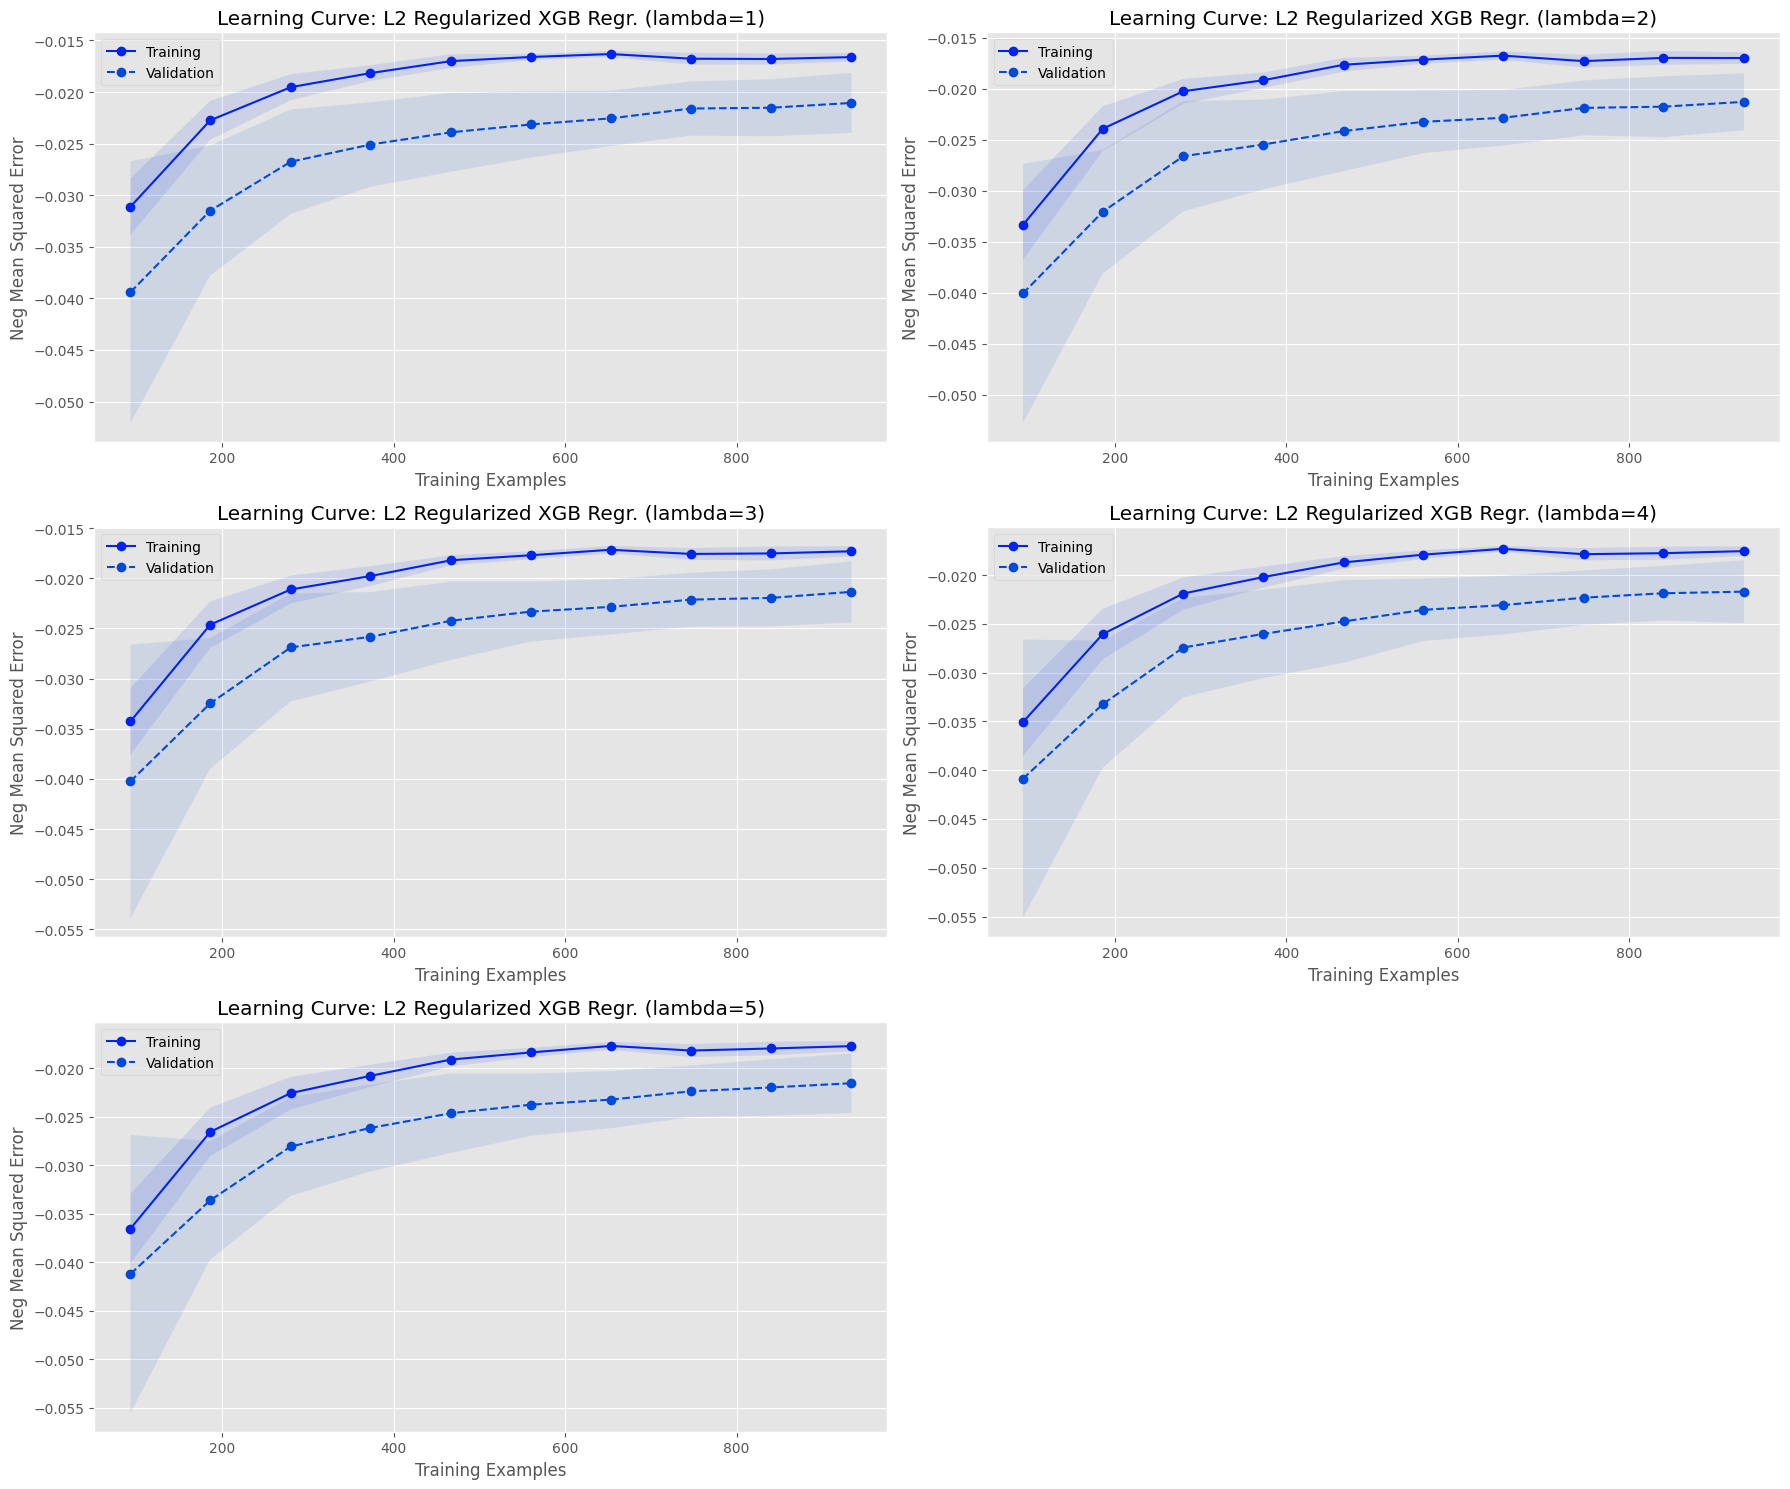

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=86)

alpha = 0.6
lambdas = [1, 2, 3, 4, 5]

plt.figure(figsize=(18, 15))

for i, lamb in enumerate(lambdas):

    plt.subplot(3, 2, i+1)
    
    plot_learning_curve(
        XGBRegressor(**best_params, reg_alpha=alpha, reg_lambda=lamb, random_state=14, n_jobs=-1),
        X_train, y_train,
        title=f"Learning Curve: L2 Regularized XGB Regr. (lambda={lamb})"
    )
    plt.tight_layout()
    
plt.savefig(os.path.join(IMAGE_PATH, '0303_xgb_l2.png'))
plt.show()

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=85)

lmbd = 3

regl_xgb = XGBRegressor(
    **best_params,
    reg_alpha=alpha,
    reg_lambda=lmbd,
    random_state=15,
    n_jobs=-1
)

regl_xgb.fit(X_train, y_train)

y_pred = regl_xgb.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Regularized XGB')    
print(f'  RMSE: {round(rmse, 4)}')
print(f'  R2: {round(r2, 4)}')

Regularized XGB
  RMSE: 0.1367
  R2: 0.8912


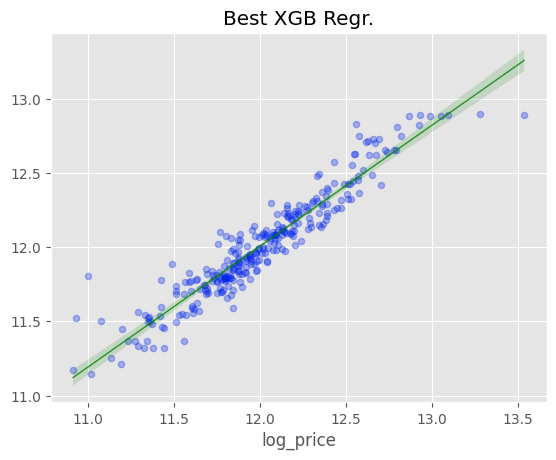

In [79]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Best XGB Regr.")
plt.show()

In [81]:
best_params.update([('reg_alpha', alpha), ('reg_lambda', lmbd)])
best_params

xgb_metrics = {
    'model': 'XGB Regr.',
    'params': f'{best_params}',
    'RMSE': rmse,
    'R2': r2
}

xgb_met_df = pd.DataFrame(xgb_metrics, index=[0])

metrics = pd.read_csv(os.path.join(METRICS_PATH, '0200_metrics.csv'), index_col=0)

metrics = pd.concat([metrics, pd.DataFrame(xgb_metrics, index=[0])])

metrics.to_csv(os.path.join(METRICS_PATH, '0300_metrics.csv'))

import joblib

joblib.dump(regl_xgb, os.path.join(MODEL_PATH, '0300_xgb_regr.joblib'))

['/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/models/0300_xgb_regr.joblib']

In [83]:
ref_data = pd.read_csv(os.path.join(PROCESSED_PATH, 'train.csv'), index_col=0)
X = ref_data.drop('log_price', axis=1)
y = ref_data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=22)

best_xgb = XGBRegressor(**best_params, random_state=22, n_jobs=-1)
best_xgb.fit(X_train, y_train)

joblib.dump(best_xgb, os.path.join(MODEL_PATH, '0301_xgb_regr.joblib'))

['/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/models/0301_xgb_regr.joblib']

3